In [1]:
!pip install feature_engine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import pickle
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from dataclasses import dataclass
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_validate
from feature_engine.encoding import WoEEncoder
from sklearn.linear_model import LogisticRegression, HuberRegressor
from sklearn.metrics import roc_auc_score

In [3]:
# Mount to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
root = '/content/drive/MyDrive/ML_final'
TRAIN_FILE = 'train.csv'
TEST_FILE = 'test.csv'

In [5]:
train_df = pd.read_csv(root + '/' + TRAIN_FILE)
test_df = pd.read_csv(root + '/' + TEST_FILE)

26570

In [28]:
# The missing value in train_df
train_df.isna().sum()

id                   0
product_code         0
loading            250
attribute_0          0
attribute_1          0
attribute_2          0
attribute_3          0
measurement_0        0
measurement_1        0
measurement_2        0
measurement_3      381
measurement_4      538
measurement_5      676
measurement_6      796
measurement_7      937
measurement_8     1048
measurement_9     1227
measurement_10    1300
measurement_11    1468
measurement_12    1601
measurement_13    1774
measurement_14    1874
measurement_15    2009
measurement_16    2110
measurement_17    2284
failure              0
dtype: int64

In [29]:
# The missing value in train_df
test_df.isna().sum()

id                   0
product_code         0
loading            223
attribute_0          0
attribute_1          0
attribute_2          0
attribute_3          0
measurement_0        0
measurement_1        0
measurement_2        0
measurement_3      329
measurement_4      409
measurement_5      508
measurement_6      624
measurement_7      720
measurement_8      846
measurement_9      904
measurement_10    1067
measurement_11    1136
measurement_12    1240
measurement_13    1303
measurement_14    1440
measurement_15    1542
measurement_16    1678
measurement_17    1740
dtype: int64

In [7]:
train_df['product_code'].value_counts()

C    5765
E    5343
B    5250
D    5112
A    5100
Name: product_code, dtype: int64

In [8]:
test_df['product_code'].value_counts()

F    5422
I    5228
G    5107
H    5018
Name: product_code, dtype: int64

In [9]:
# Reference: https://www.kaggle.com/code/medali1992/tps-aug-logistic-regression

def preprocessing(df_train, df_test):
    data = pd.concat([df_train, df_test])

    # Create three new attributes: m3_missing, m5_missing and area
    data['m3_missing'] = data['measurement_3'].isnull().astype(np.int8)
    data['m5_missing'] = data['measurement_5'].isnull().astype(np.int8)
    data['area'] = data['attribute_2'] * data['attribute_3']

    feature = [f for f in df_test.columns
               if f.startswith('measurement') or f == 'loading']

    # dictionnary of dictionnaries
    # (for the 11 best correlated measurement columns),
    # we will use the dictionnaries below to select
    # the best correlated columns according to the product code
    # Only for 'measurement_17' we make a 'manual' selection :

    full_fill_dict = {}
    full_fill_dict['measurement_17'] = {
        'A': ['measurement_5', 'measurement_6',
              'measurement_8'],
        'B': ['measurement_4', 'measurement_5',
              'measurement_7'],
        'C': ['measurement_5', 'measurement_7',
              'measurement_8', 'measurement_9'],
        'D': ['measurement_5', 'measurement_6',
              'measurement_7', 'measurement_8'],
        'E': ['measurement_4', 'measurement_5',
              'measurement_6', 'measurement_8'],
        'F': ['measurement_4', 'measurement_5',
              'measurement_6', 'measurement_7'],
        'G': ['measurement_4', 'measurement_6',
              'measurement_8', 'measurement_9'],
        'H': ['measurement_4', 'measurement_5',
              'measurement_7', 'measurement_8',
              'measurement_9'],
        'I': ['measurement_3', 'measurement_7',
              'measurement_8']
    }

    # collect the name of the next 10 best measurement columns
    # sorted by correlation (except 17 already done above):
    col = [col for col in df_test.columns if 'measurement' not in col] + \
          ['loading', 'm3_missing', 'm5_missing']

    a = []
    b = []

    for x in range(3, 17):
        corr = np.absolute(data.drop(col, axis=1).corr()[f'measurement_{x}']).sort_values(ascending=False)
        # we add the 3 first lines of the correlation values to get the "most correlated"
        a.append(np.round(np.sum(corr[1:4]), 3))
        b.append(f'measurement_{x}')

    c = pd.DataFrame()
    c['Selected columns'] = b
    c['correlation total'] = a
    c = c.sort_values(by='correlation total', ascending=False).reset_index(drop=True)
    print(f'Columns selected by correlation sum of the 3 first rows: ')
    display(c.head(10))

    for i in range(10):
        measurement_col = 'measurement_' + c.iloc[i, 0][12:]  # we select the next best correlated column
        fill_dict = {}
        for x in data.product_code.unique() : 
            corr = np.absolute(data[data.product_code == x].drop(col, axis=1).corr()[measurement_col]).sort_values(ascending=False)
            measurement_col_dic = {}
            measurement_col_dic[measurement_col] = corr[1:5].index.tolist()
            fill_dict[x] = measurement_col_dic[measurement_col]
        full_fill_dict[measurement_col] = fill_dict

    feature = [f for f in data.columns if f.startswith('measurement') or f=='loading']
    print('failure' in feature)
    nullValue_cols = [col for col in df_train.columns if df_train[col].isnull().sum()!=0]

    for code in data.product_code.unique():
        total_na_filled_by_linear_model = 0
        print(f'\n-------- Product code {code} ----------\n')
        print(f'filled by linear model :')
        for measurement_col in list(full_fill_dict.keys()):
            tmp = data[data.product_code == code]
            column = full_fill_dict[measurement_col][code]
            tmp_train = tmp[column+[measurement_col]].dropna(how='any')
            tmp_test = tmp[(tmp[column].isnull().sum(axis=1)==0)&(tmp[measurement_col].isnull())]

            model = HuberRegressor(epsilon=1.9)
            model.fit(tmp_train[column], tmp_train[measurement_col])
            data.loc[(data.product_code==code)&(data[column].isnull().sum(axis=1)==0)&(data[measurement_col].isnull()),measurement_col] = model.predict(tmp_test[column])
            print(f'{measurement_col} : {len(tmp_test)}')
            total_na_filled_by_linear_model += len(tmp_test)

        # others NA columns:
        NA = data.loc[data["product_code"] == code,nullValue_cols ].isnull().sum().sum()
        model1 = KNNImputer(n_neighbors=3)
        data.loc[data.product_code==code, feature] = model1.fit_transform(data.loc[data.product_code==code, feature])
        print(f'\n{total_na_filled_by_linear_model} filled by linear model ') 
        print(f'{NA} filled by KNN ')

    data['measurement_avg'] = data[[f'measurement_{i}' for i in range(3, 17)]].mean(axis=1)
    data['measurement_std'] = data[[f'measurement_{i}' for i in range(3, 17)]].std(axis=1)
    data['measurement_median'] = data[[f'measurement_{i}' for i in range(3, 17)]].median(axis=1)
    data['measurement_max'] = data[[f'measurement_{i}' for i in range(3, 17)]].max(axis=1)
    data['measurement_min'] = data[[f'measurement_{i}' for i in range(3, 17)]].min(axis=1)
    data['measurement_skew'] = data[[f'measurement_{i}' for i in range(3, 17)]].skew(axis=1)
    
    
    
    df_train = data.iloc[:df_train.shape[0],:]
    df_test = data.iloc[df_train.shape[0]:,:]

    woe_encoder = WoEEncoder(variables=['attribute_0'])
    woe_encoder.fit(df_train, df_train['failure'])
    df_train = woe_encoder.transform(df_train)
    df_test = woe_encoder.transform(df_test)

    features = ['loading', 'attribute_0', 'measurement_17', 'measurement_0', 'measurement_1', 'measurement_2', 'area', 'm3_missing', 'm5_missing', 'measurement_avg', 'measurement_std', 'measurement_median', 'measurement_min', 'measurement_skew']
    
    return df_train, df_test, features

df_train, df_test, features = preprocessing(train_df, test_df)

Columns selected by correlation sum of the 3 first rows: 


,Selected columns,correlation total
0,measurement_8,0.454
1,measurement_11,0.395
2,measurement_5,0.386
3,measurement_6,0.365
4,measurement_7,0.336
5,measurement_4,0.331
6,measurement_15,0.301
7,measurement_10,0.300
8,measurement_16,0.252
9,measurement_14,0.225


False

-------- Product code A ----------

filled by linear model :
measurement_17 : 386
measurement_8 : 167
measurement_11 : 225


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


measurement_5 : 113
measurement_6 : 146


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


measurement_7 : 153
measurement_4 : 79
measurement_15 : 273
measurement_10 : 209
measurement_16 : 293
measurement_14 : 237

2281 filled by linear model 
1568 filled by KNN 

-------- Product code B ----------

filled by linear model :
measurement_17 : 418
measurement_8 : 165
measurement_11 : 220
measurement_5 : 83
measurement_6 : 106
measurement_7 : 176
measurement_4 : 80
measurement_15 : 294
measurement_10 : 197
measurement_16 : 358
measurement_14 : 330

2427 filled by linear model 
1548 filled by KNN 

-------- Product code C ----------

filled by linear model :
measurement_17 : 391
measurement_8 : 211
measurement_11 : 231
measurement_5 : 141


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


measurement_6 : 150
measurement_7 : 140
measurement_4 : 110
measurement_15 : 319
measurement_10 : 262
measurement_16 : 343
measurement_14 : 340

2638 filled by linear model 
1706 filled by KNN 

-------- Product code D ----------

filled by linear model :
measurement_17 : 398
measurement_8 : 146
measurement_11 : 265
measurement_5 : 87
measurement_6 : 118
measurement_7 : 146
measurement_4 : 88
measurement_15 : 313
measurement_10 : 174
measurement_16 : 322
measurement_14 : 316

2373 filled by linear model 
1600 filled by KNN 

-------- Product code E ----------

filled by linear model :
measurement_17 : 429


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


measurement_8 : 171
measurement_11 : 244


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


measurement_5 : 116


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


measurement_6 : 127
measurement_7 : 185
measurement_4 : 105
measurement_15 : 315
measurement_10 : 193
measurement_16 : 316
measurement_14 : 297

2498 filled by linear model 
1634 filled by KNN 

-------- Product code F ----------

filled by linear model :
measurement_17 : 420
measurement_8 : 194
measurement_11 : 226


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


measurement_5 : 90
measurement_6 : 137
measurement_7 : 147
measurement_4 : 91
measurement_15 : 333
measurement_10 : 186
measurement_16 : 356
measurement_14 : 348

2528 filled by linear model 
1545 filled by KNN 

-------- Product code G ----------

filled by linear model :
measurement_17 : 373


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


measurement_8 : 188
measurement_11 : 221
measurement_5 : 104
measurement_6 : 146
measurement_7 : 145


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


measurement_4 : 93
measurement_15 : 299
measurement_10 : 226
measurement_16 : 343
measurement_14 : 268

2406 filled by linear model 
1518 filled by KNN 

-------- Product code H ----------

filled by linear model :
measurement_17 : 361


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


measurement_8 : 147
measurement_11 : 205


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


measurement_5 : 112
measurement_6 : 121
measurement_7 : 158
measurement_4 : 75
measurement_15 : 299
measurement_10 : 217
measurement_16 : 340
measurement_14 : 283

2318 filled by linear model 
1565 filled by KNN 

-------- Product code I ----------

filled by linear model :
measurement_17 : 377
measurement_8 : 192
measurement_11 : 209


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


measurement_5 : 119
measurement_6 : 132
measurement_7 : 136
measurement_4 : 89


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


measurement_15 : 350
measurement_10 : 246
measurement_16 : 294
measurement_14 : 283

2427 filled by linear model 
1402 filled by KNN 


In [10]:
df_train.head()

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,...,failure,m3_missing,m5_missing,area,measurement_avg,measurement_std,measurement_median,measurement_max,measurement_min,measurement_skew
0,0,A,80.10,0.017894,material_8,9,5,7.0,8.0,4.0,...,0.0,0,0,45,15.360919,2.776473,15.344434,20.155000,10.672,0.062681
1,1,A,84.89,0.017894,material_8,9,5,14.0,3.0,3.0,...,0.0,0,0,45,15.446286,2.540705,15.528000,18.213000,11.540,-0.356926
2,2,A,82.43,0.017894,material_8,9,5,12.0,1.0,5.0,...,0.0,0,0,45,16.098820,2.671122,16.724500,20.188481,11.652,-0.312815
3,3,A,101.07,0.017894,material_8,9,5,13.0,2.0,6.0,...,0.0,0,0,45,15.599500,2.933476,16.250000,19.060000,10.020,-0.705741
4,4,A,188.06,0.017894,material_8,9,5,9.0,2.0,8.0,...,0.0,0,0,45,15.194071,3.027182,15.964000,19.932000,10.337,-0.035574


In [11]:
features = ['product_code', 'loading', 'attribute_0', 'measurement_17', 'measurement_0', 'measurement_1', 'measurement_2', 'area', 'm3_missing', 'm5_missing', 'measurement_avg']
fit_features = ['loading', 'attribute_0', 'measurement_17', 'measurement_0', 'measurement_1', 'measurement_2', 'area', 'm3_missing', 'm5_missing', 'measurement_avg']

In [12]:
x_train, y_train = df_train.drop(columns=["failure"])[features], df_train.failure

In [13]:
x_train.head()

,product_code,loading,attribute_0,measurement_17,measurement_0,measurement_1,measurement_2,area,m3_missing,m5_missing,measurement_avg
0,A,80.10,0.017894,764.100,7.0,8.0,4.0,45,0,0,15.360919
1,A,84.89,0.017894,682.057,14.0,3.0,3.0,45,0,0,15.446286
2,A,82.43,0.017894,663.376,12.0,1.0,5.0,45,0,0,16.098820
3,A,101.07,0.017894,826.282,13.0,2.0,6.0,45,0,0,15.599500
4,A,188.06,0.017894,579.885,9.0,2.0,8.0,45,0,0,15.194071


Grid Search

In [14]:
# https://www.kaggle.com/code/grfiv4/displaying-the-results-of-a-grid-search
def GridSearch_table_plot(grid_clf, param_name,
                          num_results=15,
                          negative=True,
                          graph=True,
                          display_all_params=True):

    '''Display grid search results

    Arguments
    ---------

    grid_clf           the estimator resulting from a grid search
                       for example: grid_clf = GridSearchCV( ...

    param_name         a string with the name of the parameter being tested

    num_results        an integer indicating the number of results to display
                       Default: 15

    negative           boolean: should the sign of the score be reversed?
                       scoring = 'neg_log_loss', for instance
                       Default: True

    graph              boolean: should a graph be produced?
                       non-numeric parameters (True/False, None) don't graph well
                       Default: True

    display_all_params boolean: should we print out all of the parameters, not just the ones searched for?
                       Default: True

    Usage
    -----

    GridSearch_table_plot(grid_clf, "min_samples_leaf")

                          '''
    from matplotlib import pyplot as plt
    from IPython.display import display
    import pandas as pd

    clf = grid_clf.best_estimator_
    clf_params = grid_clf.best_params_
    if negative:
        clf_score = -grid_clf.best_score_
    else:
        clf_score = grid_clf.best_score_
    clf_stdev = grid_clf.cv_results_['std_test_score'][grid_clf.best_index_]
    cv_results = grid_clf.cv_results_

    print("best parameters: {}".format(clf_params))
    print("best score:      {:0.5f} (+/-{:0.5f})".format(clf_score, clf_stdev))
    if display_all_params:
        import pprint
        pprint.pprint(clf.get_params())

    # pick out the best results
    # =========================
    scores_df = pd.DataFrame(cv_results).sort_values(by='rank_test_score')

    best_row = scores_df.iloc[0, :]
    if negative:
        best_mean = -best_row['mean_test_score']
    else:
        best_mean = best_row['mean_test_score']
    best_stdev = best_row['std_test_score']
    best_param = best_row['param_' + param_name]

    # display the top 'num_results' results
    # =====================================
    display(pd.DataFrame(cv_results)
            .sort_values(by='rank_test_score').head(num_results))

    # plot the results
    # ================
    scores_df = scores_df.sort_values(by='param_' + param_name)

    if negative:
        means = -scores_df['mean_test_score']
    else:
        means = scores_df['mean_test_score']
    stds = scores_df['std_test_score']
    params = scores_df['param_' + param_name]

    # plot
    if graph:
        plt.figure(figsize=(8, 8))
        plt.errorbar(params, means, yerr=stds)

        plt.axhline(y=best_mean + best_stdev, color='red')
        plt.axhline(y=best_mean - best_stdev, color='red')
        plt.plot(best_param, best_mean, 'or')

        plt.title(param_name + " vs Score\nBest Score {:0.5f}".format(clf_score))
        plt.xlabel(param_name)
        plt.ylabel('Score')
        plt.show()

In [15]:
# Reference: https://www.kaggle.com/code/purist1024/principled-3-vs-2-cv-splitting-on-product-code/notebook
class ProductSplitter3v2_Grid():
    """A speclialized CrossValidator for TPS2208 which splits between product codes. Each split includes 3
    products in the train set and 2 in the validation set."""
    def split(self, X: pd.DataFrame, groups):
        indices = list(X.groupby(groups).indices.values())
        for i in range(len(indices)):
            for j in range(i + 1, len(indices)):
                yield [
                    np.concatenate([ix for k, ix in enumerate(indices) if k not in [i, j]]),
                    np.concatenate([ix for k, ix in enumerate(indices) if k in [i, j]])
                ]

In [16]:
c_values = [10, 1.0, 0.1, 0.01]
solvers = ['lbfgs', 'liblinear', 'newton-cg']
grid = dict(C=c_values, solver=solvers)

model = LogisticRegression(max_iter=500, dual=False, penalty="l2")
cv = ProductSplitter3v2_Grid().split(X=x_train.drop(['product_code'], axis=1), groups=x_train['product_code'])
grid_search = GridSearchCV(estimator=model, param_grid=grid, cv=cv, scoring='roc_auc', error_score=0)

In [17]:
grid_result = grid_search.fit(x_train.drop(['product_code'], axis=1), y_train)

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linese

best parameters: {'C': 0.01, 'solver': 'newton-cg'}
best score:      0.58912 (+/-0.00412)
{'C': 0.01,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 500,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'newton-cg',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
11,1.041316,0.086620,0.010122,0.000920,0.01,newton-cg,"{'C': 0.01, 'solver': 'newton-cg'}",0.591562,0.584855,0.595098,0.587736,0.590346,0.595947,0.583599,0.589235,0.583723,0.589121,0.589122,0.004117,1
8,1.113540,0.090000,0.009912,0.000405,0.1,newton-cg,"{'C': 0.1, 'solver': 'newton-cg'}",0.591433,0.585474,0.594677,0.587507,0.590427,0.594529,0.583803,0.589207,0.583952,0.589433,0.589044,0.003717,2
5,1.227947,0.131161,0.009852,0.000243,1.0,newton-cg,"{'C': 1.0, 'solver': 'newton-cg'}",0.591112,0.585752,0.594593,0.587414,0.590300,0.593982,0.583826,0.588951,0.584377,0.590088,0.589040,0.003530,3
2,1.354493,0.092909,0.009818,0.000219,10,newton-cg,"{'C': 10, 'solver': 'newton-cg'}",0.591061,0.585869,0.594720,0.587356,0.590280,0.593910,0.583827,0.588793,0.583858,0.590433,0.589011,0.003613,4
4,0.098331,0.013076,0.010190,0.000574,1.0,liblinear,"{'C': 1.0, 'solver': 'liblinear'}",0.591453,0.584192,0.594534,0.588164,0.588603,0.593498,0.586282,0.588070,0.582111,0.588681,0.588559,0.003670,5
7,0.097894,0.013966,0.009985,0.000382,0.1,liblinear,"{'C': 0.1, 'solver': 'liblinear'}",0.591492,0.583549,0.594534,0.588183,0.589034,0.594591,0.584376,0.587950,0.582502,0.588843,0.588505,0.004010,6
10,0.086552,0.008232,0.010232,0.000453,0.01,liblinear,"{'C': 0.01, 'solver': 'liblinear'}",0.591934,0.583334,0.594431,0.588467,0.588642,0.594335,0.585103,0.587825,0.581927,0.588727,0.588473,0.004037,7
1,0.100302,0.012850,0.010265,0.000832,10,liblinear,"{'C': 10, 'solver': 'liblinear'}",0.591448,0.583276,0.595022,0.588154,0.588982,0.594623,0.583917,0.587534,0.582744,0.588726,0.588443,0.004141,8
0,0.352748,0.112522,0.011608,0.002762,10,lbfgs,"{'C': 10, 'solver': 'lbfgs'}",0.591920,0.583931,0.594581,0.588154,0.588095,0.594274,0.584610,0.588050,0.582597,0.588080,0.588429,0.003918,9
9,0.294160,0.078498,0.012580,0.005297,0.01,lbfgs,"{'C': 0.01, 'solver': 'lbfgs'}",0.592659,0.582656,0.594540,0.588302,0.588158,0.594378,0.584751,0.587157,0.582069,0.587924,0.588259,0.004238,10


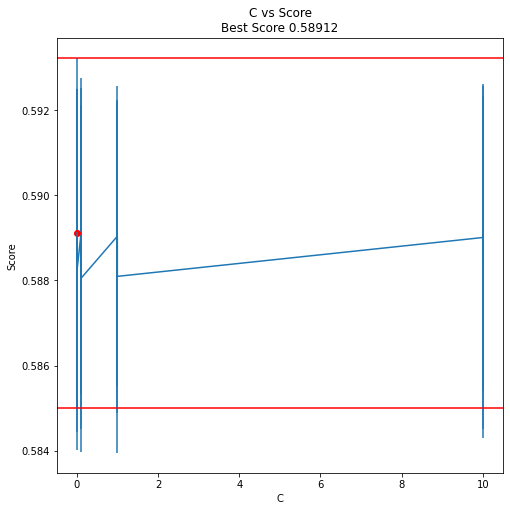

In [18]:
GridSearch_table_plot(grid_search, "C", negative=False)

In [19]:
c, solver = 0.01, 'newton-cg'

Cross validation function

In [20]:
@dataclass
class ProductSplitter3v2():
    """A speclialized CrossValidator for TPS2208 which splits between product codes. Each split includes 3
    products in the train set and 2 in the validation set."""
    def split(self, X: pd.DataFrame, _y=None, _groups=None):
        indices = list(X.groupby("product_code").indices.values())
        for i in range(len(indices)):
            for j in range(i + 1, len(indices)):
                yield [
                    np.concatenate([ix for k, ix in enumerate(indices) if k not in [i, j]]),
                    np.concatenate([ix for k, ix in enumerate(indices) if k in [i, j]])
                ]

In [21]:
@dataclass
class TransformTPS2208(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self # We don't need to train this transformer
    def transform(self, X):
        return X[fit_features]

In [22]:
x_train.head()

,product_code,loading,attribute_0,measurement_17,measurement_0,measurement_1,measurement_2,area,m3_missing,m5_missing,measurement_avg
0,A,80.10,0.017894,764.100,7.0,8.0,4.0,45,0,0,15.360919
1,A,84.89,0.017894,682.057,14.0,3.0,3.0,45,0,0,15.446286
2,A,82.43,0.017894,663.376,12.0,1.0,5.0,45,0,0,16.098820
3,A,101.07,0.017894,826.282,13.0,2.0,6.0,45,0,0,15.599500
4,A,188.06,0.017894,579.885,9.0,2.0,8.0,45,0,0,15.194071


In [23]:
model = make_pipeline(TransformTPS2208(), LogisticRegression(max_iter=500, C=c, solver=solver))
cv = cross_validate(model, x_train, y_train, cv=ProductSplitter3v2(), scoring='roc_auc', return_estimator=True)
print("Scores:", cv['test_score'])
print(f"avg={np.mean(cv['test_score'])}; std={np.std(cv['test_score'])}")

/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.8/dist-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/usr/local/lib/python3.8/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not c

Scores: [0.59156151 0.58485474 0.5950979  0.58773617 0.59034617 0.595947
 0.58359916 0.58923498 0.58372319 0.58912095]
avg=0.5891221769137565; std=0.00411744227351578


In [24]:
# Average the prediction from 10 models
models = []
for i in range(10):
    clf = cv['estimator'][i]['logisticregression']
    models.append(clf)

In [25]:
with open(root + '/' + "models.pckl", "wb") as f:
    for model in models:
        pickle.dump(model, f)